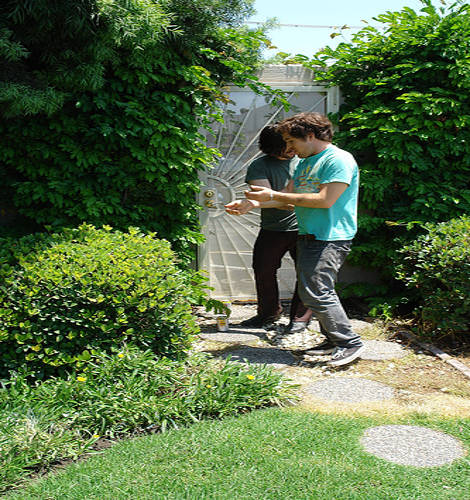

['Two young guys with shaggy hair look at their hands while hanging out in the yard.', 'Two young, White males are outside near many bushes.', 'Two men in green shirts are standing in a yard.', 'A man in a blue shirt standing in a garden.', 'Two friends enjoy time spent together.']


In [ ]:
# load dataset
import transformers
import requests
import io
from datasets import load_dataset
from PIL import Image
from IPython.display import display
data_files = {
    'train' : '../dataset/0000.parquet',
    'test' : '../dataset/0001.parquet'
}
dataset = load_dataset('parquet', data_files=data_files)
train = dataset['train']

image = train['image'][0].convert('RGB')
caption = train['caption'][0]
display(image.resize((470,500)))
print(caption)

In [ ]:
# load model, tokenizer and processor
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
from transformers import AutoProcessor, Blip2ForConditionalGeneration, AutoTokenizer
import torch
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
tokenizer = AutoTokenizer.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

Trying to resume download...
Trying to resume download...
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


In [ ]:
# lora config
from peft import LoraConfig, get_peft_model
config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none"
)
model.half()
model = get_peft_model(model, config)
model.print_trainable_parameters()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

trainable params: 2,621,440 || all params: 3,747,301,376 || trainable%: 0.0700


PeftModel(
  (base_model): LoraModel(
    (model): Blip2ForConditionalGeneration(
      (vision_model): Blip2VisionModel(
        (embeddings): Blip2VisionEmbeddings(
          (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
        )
        (encoder): Blip2Encoder(
          (layers): ModuleList(
            (0-38): 39 x Blip2EncoderLayer(
              (self_attn): Blip2Attention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): Linear(in_features=1408, out_features=4224, bias=True)
                (projection): Linear(in_features=1408, out_features=1408, bias=True)
              )
              (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
              (mlp): Blip2MLP(
                (activation_fn): GELUActivation()
                (fc1): Linear(in_features=1408, out_features=6144, bias=True)
                (fc2): Linear(in_features=6144, out_features=1408, bias=True)
              )
              

In [ ]:
#preprocess data
from torch.utils.data import DataLoader, Dataset
class ImageCaptionDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,idx):
        item = self.dataset[idx]
        prompt = "A short image caption:"
        encoding = self.processor(images=item['image'], text=prompt, return_tensors="pt")
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding['caption'] = item['caption']
        return encoding

def collator(batch):
    processed_batch = {}
    for key in batch[0].keys():
        if key != 'caption': # get all pixel_values
            processed_batch[key] = torch.stack([k[key] for k in batch])
        else:
            
            captions = [k['caption'][0] for k in batch] # Because the 'caption' from original dataset is a list of captions

            caption_inputs = processor.tokenizer(
                captions, padding = True, return_tensors = "pt"
            )


            processed_batch['input_ids'] = caption_inputs['input_ids']
            processed_batch['attention_mask'] = caption_inputs['attention_mask']
    
    return processed_batch

train_dataset = ImageCaptionDataset(train, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2, collate_fn=collator)


In [ ]:
# lora train
from torch import autograd

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-5)

model.train()
loss_list=[]
for epoch in range(2):
    print("Epoch:", epoch)
    sum_loss_list = []
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device, torch.float16)
        if idx % 10 == 0: 
            generated_output = model.generate(pixel_values=pixel_values, max_new_tokens=20)
            print(processor.batch_decode(generated_output, skip_special_tokens=True))
        # print("Shape of input_ids:", input_ids.shape)
        # # print("Shape of pixel_values:", pixel_values.shape)
        # print(input_ids)
        # print(pixel_values)
        #语言模型输入=输出
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
        print(outputs)
        loss = outputs.loss

        print("Loss:", loss.item())

        sum_loss_list.append(float(loss.item()))
        with autograd.detect_anomaly():
            loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        if idx % 10 == 0: 
            generated_output = model.generate(pixel_values=pixel_values, max_new_tokens=20)
            print(processor.batch_decode(generated_output, skip_special_tokens=True))
        model.print_trainable_parameters()

    avg_sum_loss = sum(sum_loss_list) / len(sum_loss_list)
    print("epoch: ", epoch, "loss: ", float(avg_sum_loss))
    loss_list.append(float(avg_sum_loss))

In [ ]:
# save model
model.save_pretrained('./trained_model')